In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit
import math

In [2]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

def make_plots(QDP,retention):
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        if QDP.experiments[0]['variable_list']==[]:
            data=range(0,np.size(retention['ivar'],axis=1))
            xlab = 'iteration'
        else:
            xlab = QDP.experiments[0]['variable_desc'][QDP.experiments[0]['variable_list'][0]]['description']
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    plt.show()
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()

# Set experiment to analyze


In [7]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
exp_id='2018_03_04_21_49_19_Closed loop, Fxed tgap Ramsey, N=500'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()

In [12]:
retention = q.apply_thresholds(dataset=range(0,54))

<IPython.core.display.Javascript object>


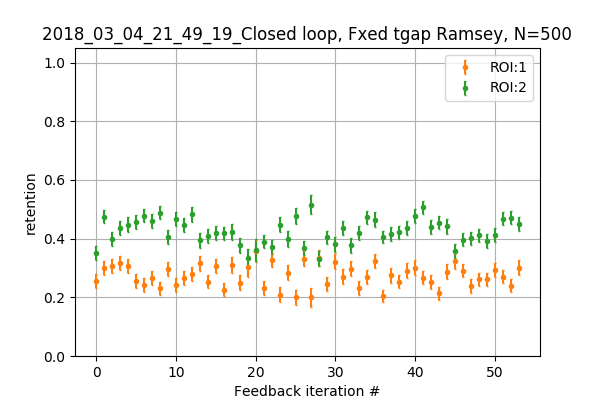

In [16]:
savefig=True
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
fit_guesses=[30,0.4,2,0,0.5]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    error=0
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
#     guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
#     try:
#         fit,pcov = curve_fit(decaying_sin,data,reten,guesses)
#     except RuntimeError:
#         error=1
#     if error is not 1:
#         print "ROI:{}, tau : {}, amplitude {} , freq:{}, phase:{}, offset:{}".format(roi,fit[0],fit[1],fit[2],fit[3],fit[4])
#         fitted_parameters.append(fit[0])
#         xarray=np.linspace(np.min(data),np.max(data),100)
#         yfit=decaying_sin(xarray, fit[0],fit[1],fit[2],fit[3],fit[4])
#         plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1.05)
#ax.set_xlim(-0.5,20)
ax.grid()
#ax.set_xlabel(xlab)
ax.set_xlabel('Feedback iteration #')
ax.set_ylabel('retention')
ax.legend()
if savefig:
    fig.savefig(exp_id+'atom_Retention.pdf')
    fig.savefig(exp_id+'atom_Retention.png')

# Camera plots, red

<IPython.core.display.Javascript object>


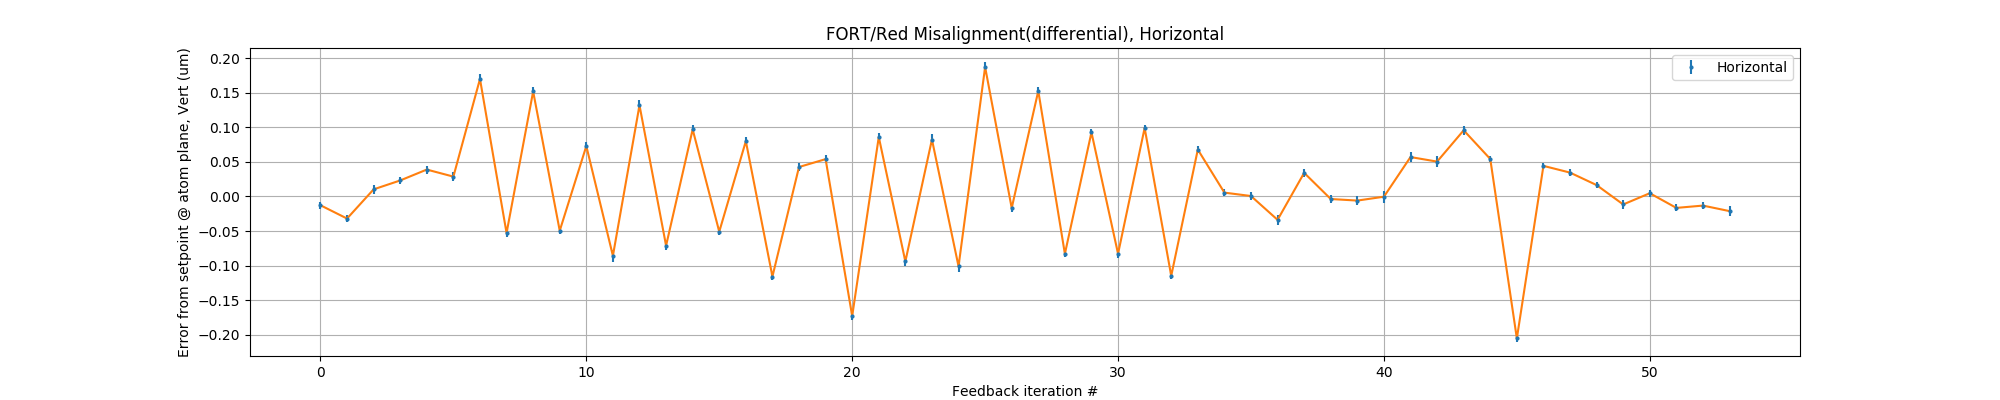

54
54


<IPython.core.display.Javascript object>


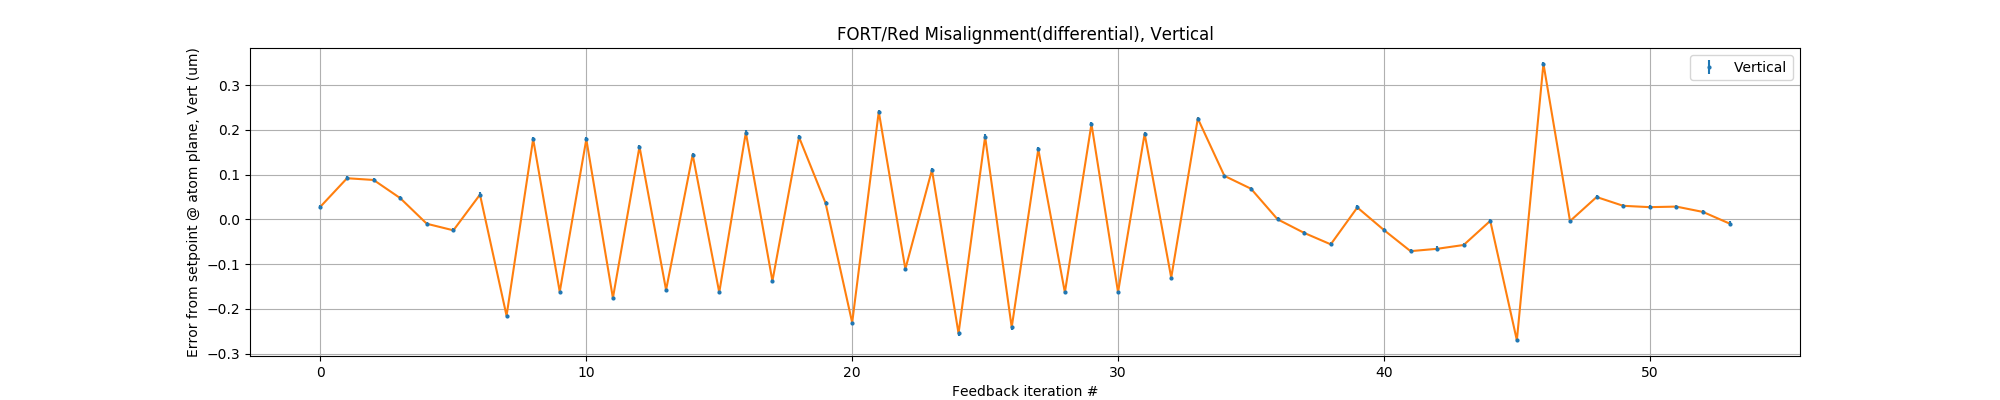

<IPython.core.display.Javascript object>


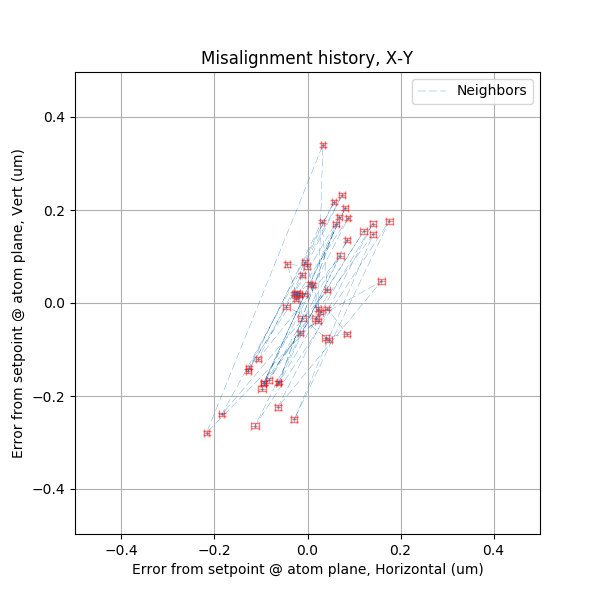

In [20]:
savefig=True
figW=20
figH=4
whichside='AAS_redside' #'AAS_
#whichside='AAS_redside'
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
xdata = []
ydata = []
yerr = []
target=np.array([-101.742,-43.384])
sample_numbers=500
user_specified=54
iteration_range=range(min(len(np.squeeze(retention['ivar'])),user_specified))
for e in iteration_range:
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['x'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_x'])
print np.size(xdata)    
print np.size(ydata)
offset=target[0]#np.mean(ydata)
Xcoord=ydata-offset
Xcoord_err=yerr
ax.errorbar(xdata,Xcoord,yerr=np.array(yerr)/(np.sqrt(sample_numbers)),fmt='o',markersize=2,label='Horizontal')
ax.plot(xdata,Xcoord)

plt.show()
#ax.set_title(exp_id)
ax.set_title('FORT/Red Misalignment(differential), Horizontal')
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.grid()
ax.legend()
ax.set_xlabel('Feedback iteration #')
if savefig:
    fig.savefig(exp_id+'Camera_X.pdf')
    fig.savefig(exp_id+'Camera_X.png')

fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
xdata = []
ydata = []
yerr = []
iteration_range=range(min(len(np.squeeze(retention['ivar'])),user_specified))
for e in iteration_range:
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['y'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_y'])
offset=target[1]
Ycoord=ydata-offset
Ycoord_err=yerr
ax.set_title('FORT/Red Misalignment(differential), Vertical')
ax.errorbar(xdata,Ycoord,yerr=np.array(yerr)/(np.sqrt(sample_numbers)),fmt='o',markersize=2,label='Vertical')
ax.plot(xdata,Ycoord)

#ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.grid()
ax.legend()
ax.set_xlabel('Feedback iteration #')
if savefig:
    fig.savefig(exp_id+'Camera_Y.pdf')
    fig.savefig(exp_id+'Camera_Y.png')

fig, ax = plt.subplots()
fig.set_size_inches(6,6)
length_conversion=1.0 # Red gives already in um units
cutoff=-1
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmean(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])/math.sqrt(sample_numbers)
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmean(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])/math.sqrt(sample_numbers)
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='red',elinewidth=0.5,markersize=1,capsize=3,alpha=0.5)
ax.plot(xdata,ydata,'--',linewidth=0.2,label='Neighbors')

ax.set_title('Misalignment history, X-Y')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel('Error from setpoint @ atom plane, Horizontal (um)')
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()
if savefig:
    fig.savefig(exp_id+'Camera Beam history.pdf')
    fig.savefig(exp_id+'Camera Beam history.png')

In [77]:
q.experiments[0]['iterations'][0]

{'AAS_blueside': {},
 'AAS_redside': {'ctrl_x': -0.10053049778375971,
  'ctrl_y': -0.59898671295941097,
  'error_x': -0.36295879694336008,
  'error_y': -1.7033885760300223,
  'sigma_x': 0.05667258028647764,
  'sigma_y': 0.056232172550881178,
  'x': -101.07024656641195,
  'y': -45.368050951997496},
 'FORT_camera_dataX': 224.26534271505133,
 'FORT_camera_dataY': 48.81424368500582,
 'Red_camera_dataX': 325.33077444646483,
 'Red_camera_dataY': 94.197098932998756,
 'loaded': array([ 0.,  0.,  0.,  0.,  0.]),
 'loading': array([ 0.,  0.,  0.,  0.,  0.]),
 'quantized_data': array([[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        ..., 
        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
        

# Actuator plot

<IPython.core.display.Javascript object>


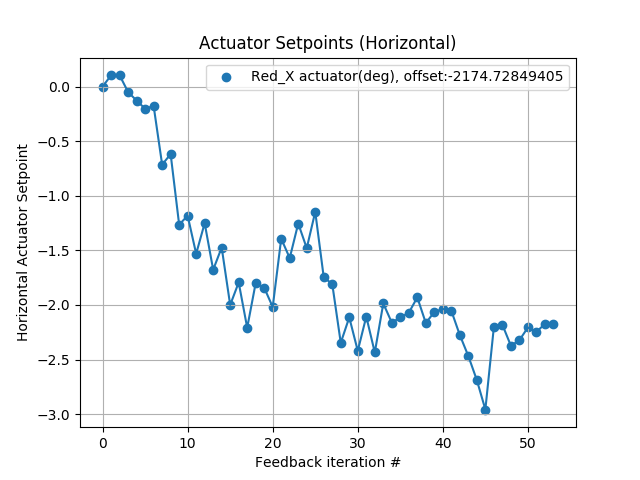

<IPython.core.display.Javascript object>


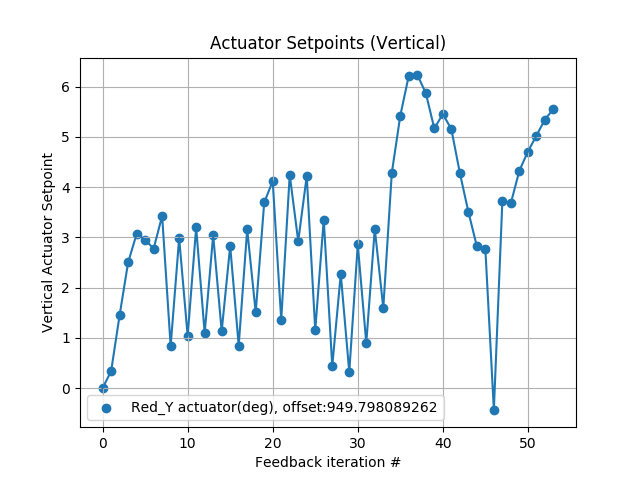

<IPython.core.display.Javascript object>


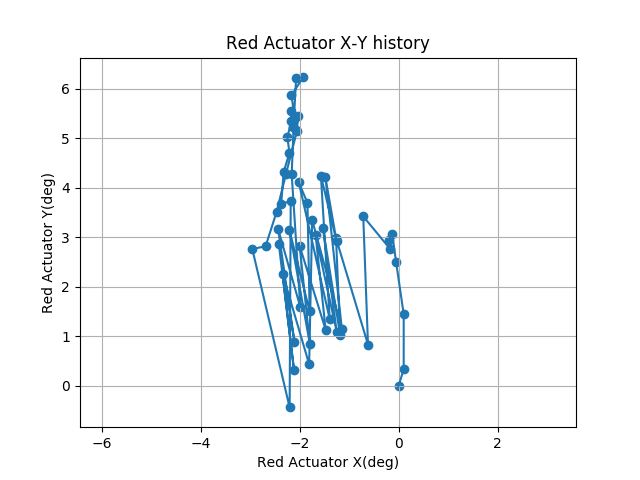

In [21]:
## X actuator plot
fig, ax = plt.subplots()
xdata = []
ydata = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['variables']['Red_X'])
offset=ydata[0]#np.median(ydata)
Xactuator=ydata-offset
ax.scatter(xdata,Xactuator,label='Red_X actuator(deg), offset:{}'.format(offset))
ax.plot(xdata,Xactuator)
#ax.set_title(exp_id)
ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel('Feedback iteration #')
ax.set_ylabel('Horizontal Actuator Setpoint')
ax.grid()
ax.legend()
plt.show()
if savefig:
    fig.savefig(exp_id+'actuatorX.pdf')
    fig.savefig(exp_id+'actuatorX.png')

## Y actuator plot
fig, ax = plt.subplots()
xdata = []
ydata = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['variables']['Red_Y'])
offset=ydata[0]
Yactuator=ydata-offset
ax.scatter(xdata,Yactuator,label='Red_Y actuator(deg), offset:{}'.format(offset))
ax.plot(xdata,Yactuator)


#ax.set_title(exp_id)
ax.set_title('Actuator Setpoints (Vertical)')
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel('Feedback iteration #')
ax.set_ylabel('Vertical Actuator Setpoint')
ax.grid()
ax.legend()
if savefig:
    fig.savefig(exp_id+'actuatorY.pdf')
    fig.savefig(exp_id+'actuatorY.png')
##
fig, ax = plt.subplots()
length_conversion=1.0 # Red gives already in um units
cutoff=-1
xdata=Xactuator[0:cutoff]
ydata=Yactuator[0:cutoff]
ax.plot(xdata,ydata)
ax.scatter(xdata,ydata)
ax.set_title('Red Actuator X-Y history')
#ax.set_xlim(-1,1)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Red Actuator X(deg)')
ax.set_ylabel('Red Actuator Y(deg)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()
if savefig:
    fig.savefig(exp_id+'actuatorXY.pdf')
    fig.savefig(exp_id+'actuatorXY.png')

<IPython.core.display.Javascript object>


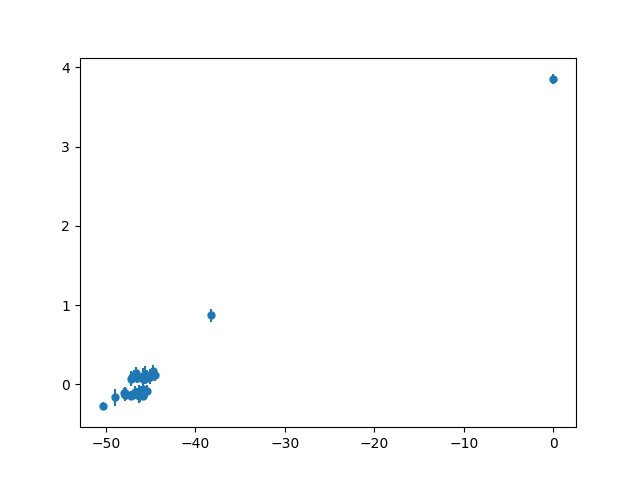

<IPython.core.display.Javascript object>


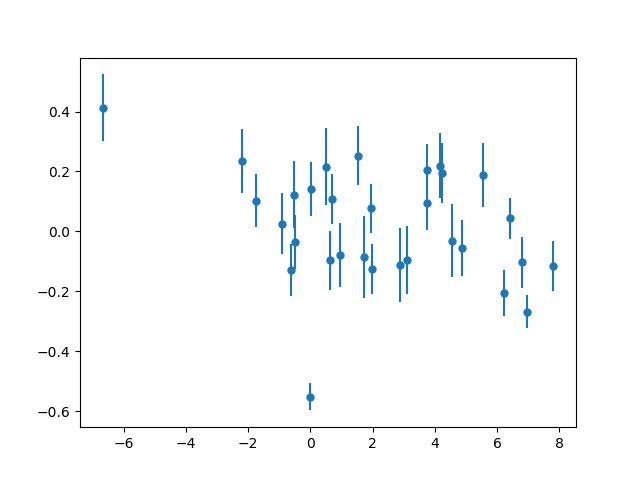

<Container object of 3 artists>

In [67]:
fig, ax = plt.subplots()
ax.errorbar(Xactuator,Xcoord,yerr=Xcoord_err,fmt='o',markersize=5)
fig, ax = plt.subplots()
ax.errorbar(Yactuator,Ycoord,yerr=Ycoord_err,fmt='o',markersize=5)

<IPython.core.display.Javascript object>

AttributeError: Unknown property fmt

<IPython.core.display.Javascript object>


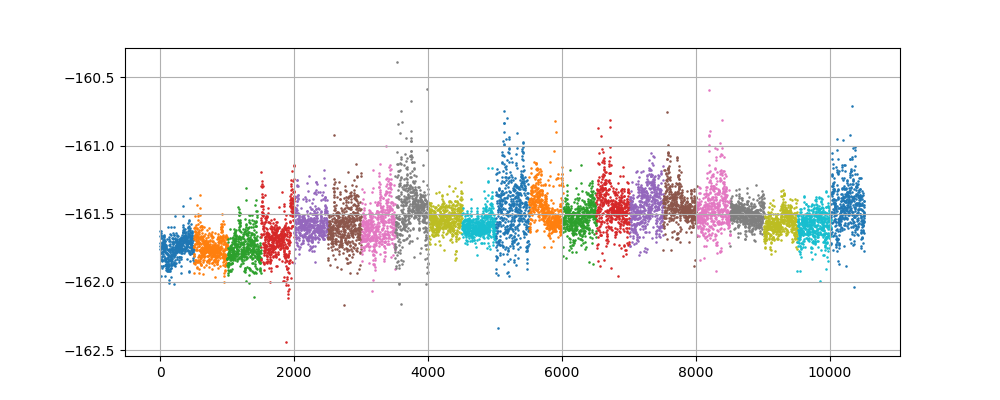

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
for e in range(len(np.squeeze(retention['ivar']))):
    data1=np.array(q.experiments[0]['iterations'][e]['FORT_camera_dataX'])
    data2=np.array(q.experiments[0]['iterations'][e]['Red_camera_dataX'])
    x=np.array(range(0,np.size(data1)))
    ax.scatter(x+np.size(data1)*e,data1-data2,s=0.7) #in microns

#ax.set_title(exp_id)
#ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(5500,6700)
#ax.set_ylim(-10, 10)
#ax.set_xlabel('Feedback iteration #')
#ax.set_ylabel('Horizontal Actuator Setpoint')
ax.grid()
ax.legend()
plt.show()


<IPython.core.display.Javascript object>


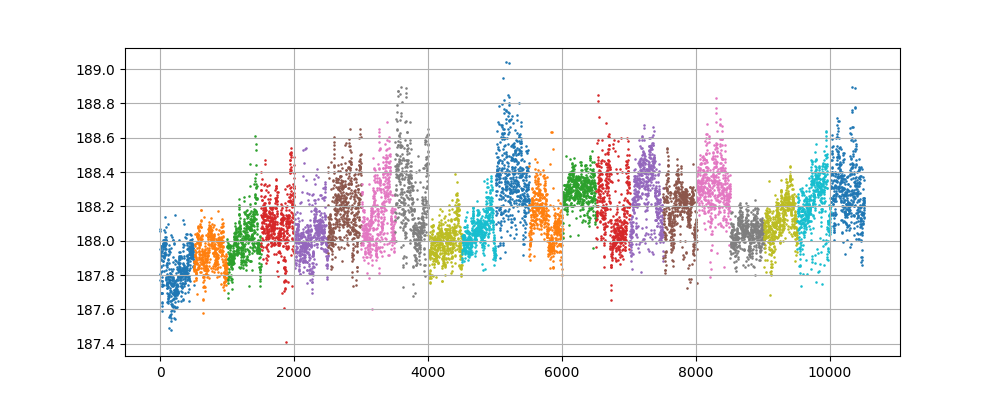

<IPython.core.display.Javascript object>


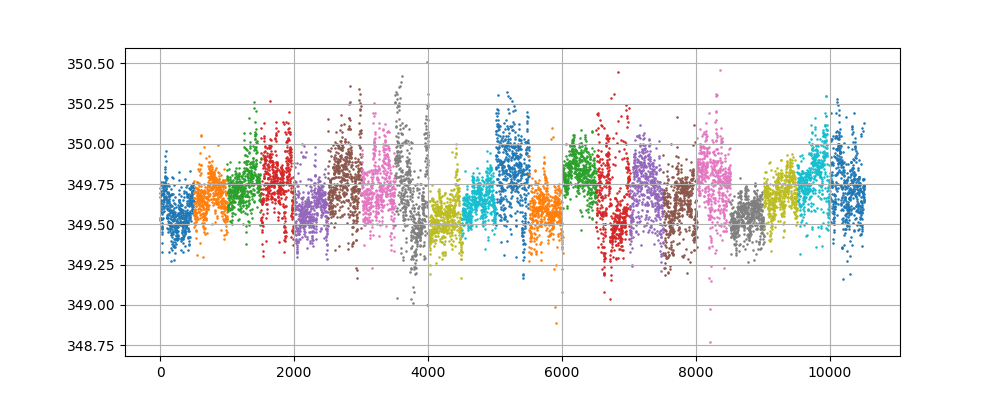

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
for e in range(len(np.squeeze(retention['ivar']))):
    data1=np.array(q.experiments[0]['iterations'][e]['FORT_camera_dataX'])
    x=np.array(range(0,np.size(data1)))
    ax.scatter(x+np.size(data1)*e,data1,s=0.7) #in microns

#ax.set_title(exp_id)
#ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
#ax.set_xlabel('Feedback iteration #')
#ax.set_ylabel('Horizontal Actuator Setpoint')
#ax.set_xlim(5000,6000)
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(10,4)
for e in range(len(np.squeeze(retention['ivar']))):
    #data1=np.array(q.experiments[0]['iterations'][e]['FORT_camera_dataX'])
    data2=np.array(q.experiments[0]['iterations'][e]['Red_camera_dataX'])
    x=np.array(range(0,np.size(data2)))
    ax.scatter(x+np.size(data2)*e,data2,s=0.7) #in microns


#ax.set_title(exp_id)
#ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(0,2000)
#ax.set_ylim(-10, 10)
#ax.set_xlabel('Feedback iteration #')
#ax.set_ylabel('Horizontal Actuator Setpoint')
#ax.set_xlim(5000,6000)
ax.grid()
ax.legend()
plt.show()

In [74]:
len(np.squeeze(retention['ivar']))

301